Urban Data Science & Smart Cities <br>
URSP688Y Spring 2025<br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

# Demo 9 - Network Analysis

Today, I'm introducing network analysis with a Python package called [OSMnx](https://osmnx.readthedocs.io/en/stable/) that both downloads and analyzes street networks from OpenStreetMap (OSM). This package was written by Geoff Boeing, now at USC, while he was in grad school, a demonstration of how grad students with an interest in coding can author open-source tools with influence that stretches far beyond their own work.

Beneath the hood, OSMnx relies on a network analysis package called [NetworkX](https://networkx.org/); it's one of the dominant Python tools for storing and analyzing networks, or as mathematicians tend to call them, "graphs."

A network or graph, I'll use these terms interchangeably, is made up of "nodes" or "vertices"—the objects that are related to one another—and "edges" or "links"—connections that define relationships between nodes. In a street network, you can think of the nodes as intersections and the edges as street segments. You could also, however, use a graph to represent more abstract concepts, such as communities. Social network models, for example, use nodes to represent people and edges to represent relationships between them. You could imagine adding attributes to those edges to represent the strength of different relationship (e.g., strong or weak ties), just as length, speed limit, or lane counts along edges in a street network are indicators of connection between two intersections.

The following graph has 6 nodes and edges making direct connections between certain pairs of nodes but not others.

<img alt="basic graph" width=300 src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/6n-graf.svg/1920px-6n-graf.svg.png">

We're going to practice analyzing a street network today in terms of shortest paths, a common type of analysis in transportation planning. Another common way of analyzing graphs is based on "degree," the number of nodes connected to a given node. A graph where all nodes are connected to each other would have high "degree centrality," while a graph where nodes are not very well-connected would have low centrality.

Let's install OSMnx, which will automatically install NetworkX as a dependency.

We'll first build a basic graph in NetworkX to demonstrate how it works. Then we'll use OSMnx to download an OSM street network and calculate shortest paths across it.

In [ ]:
# Install OSMNX
# !pip install osmnx

In [145]:
import os
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Build a Basic Graph

Can we build the same graph pictured here in NetworkX?

<img alt="basic graph" width=300 src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/6n-graf.svg/1920px-6n-graf.svg.png">

In [32]:
# Create an empty graph
G = nx.Graph()

In [34]:
# Add nodes to the graph
for id in range(1,7):
    G.add_node(id)

In [155]:
G[1]

AtlasView({5: {}, 2: {}})

In [35]:
G.add_edge(1, 5)
G.add_edge(1, 2)
G.add_edge(2, 5)
G.add_edge(5, 4)
G.add_edge(3, 4)
G.add_edge(3, 2)
G.add_edge(6, 4)

In [151]:
G.nodes()

NodeView((1, 2, 3, 4, 5, 6, 'Chester', 8.19))

In [50]:
G.edges()

EdgeView([(1, 5), (1, 2), (2, 5), (2, 3), (3, 4), (4, 5), (4, 6)])

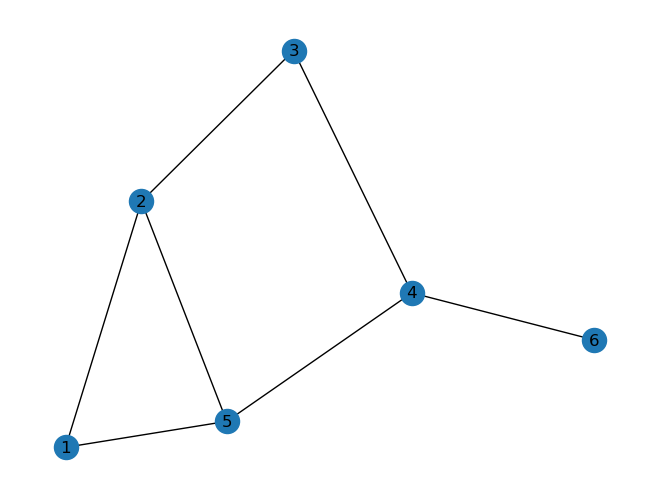

In [102]:
# Draw the graph with labels
nx.draw(G, with_labels=True)

In [94]:
# Degrees from a given node
G.degree(5)

3

In [53]:
# Centrality for each vertex
# (degrees / count of other nodes)
nx.degree_centrality(G)

{1: 0.4,
 2: 0.6000000000000001,
 3: 0.4,
 4: 0.6000000000000001,
 5: 0.6000000000000001,
 6: 0.2}

In [57]:
# Average centrality
sum(nx.degree_centrality(G).values()) / len(nx.degree_centrality(G))

0.46666666666666673

In [60]:
np.mean(list(nx.degree_centrality(G).values()))

np.float64(0.46666666666666673)

In [62]:
# Shortest path
nx.shortest_path(G, 1, 4)

[1, 5, 4]

# Analyzing a Street Network

## Load a street network from OSM

In [64]:
# Define coordinate systems
UTM18 = 26918
WGS84 = 4326

In [65]:
# Retrieve the street network for Washington, DC
place = 'Washington, DC, USA'
dc_network_g = ox.graph_from_place(place, network_type='drive')
dc_network_g = ox.project_graph(dc_network_g, to_crs=UTM18)
# Convert to geodataframes for easy plotting and exploration
dc_network_nodes, dc_network_edges = ox.graph_to_gdfs(dc_network_g)

In [119]:
# dc_network_edges

## Load other data

In [72]:
# Load affordable housing points
affordable_housing = gpd.read_file('Affordable_Housing.geojson').to_crs(UTM18)

In [75]:
# Load Metro Center point
metro_center = gpd.points_from_xy([-77.032774], [38.8985198])
metro_center = gpd.GeoDataFrame(geometry=metro_center, crs=WGS84).to_crs(epsg=UTM18)

<Axes: >

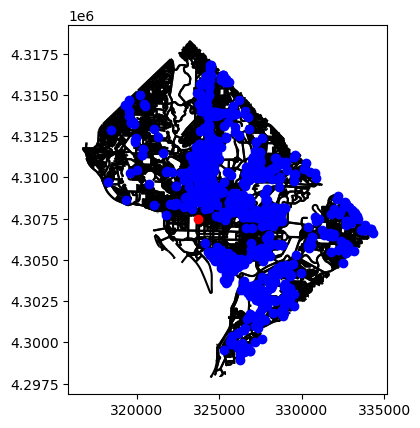

In [78]:
# Map data to make sure everything lines up
ax = dc_network_edges.plot(color='black', zorder=1)
affordable_housing.plot(ax=ax, color='blue', zorder=2)
metro_center.plot(ax=ax, color='red', zorder=3)

## Relate points to street network

In [86]:
dc_network_g[49184747][49198976][0]

{'osmid': 6055425,
 'highway': 'primary',
 'lanes': '2',
 'maxspeed': '25 mph',
 'name': 'Western Avenue Northwest',
 'oneway': False,
 'reversed': False,
 'length': 70.46209387608218}

In [87]:
# Find the nearest node to metro center
metro_center_nodes, metro_center_node_dists = ox.nearest_nodes(
    dc_network_g,
    metro_center.geometry.get_coordinates().x, 
    metro_center.geometry.get_coordinates().y, 
    return_dist=True)

In [88]:
metro_center_nodes

array([49745629])

In [89]:
metro_center_node_dists

array([74.35849321])

In [90]:
# Find the nearest nodes to affordable housing units
affordable_housing_nodes, affordable_housing_node_dists = ox.nearest_nodes(
    dc_network_g,
    affordable_housing.geometry.get_coordinates().x,
    affordable_housing.geometry.get_coordinates().y,
    return_dist=True)

In [141]:
len(affordable_housing.geometry.get_coordinates().x)

924

In [142]:
affordable_housing_nodes[:5]

array([  49778464,  655442834,   49760649,   49772340, 1364961085])

In [92]:
affordable_housing_node_dists[:5]

array([ 40.21723283,  31.27785737,  76.46442434, 100.67532   ,
        61.74240405])

## Calculate shortest path

In [116]:
# Calculate shortest path
affordable_housing_node = affordable_housing_nodes[10]
metro_center_node = metro_center_nodes[0]

route = ox.shortest_path(
    dc_network_g, 
    affordable_housing_node, 
    metro_center_node, 
    weight='length',
)

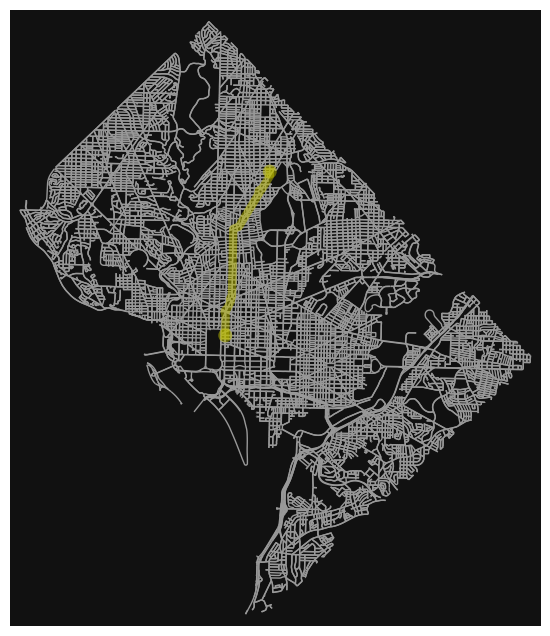

In [117]:
fig, ax = ox.plot_graph_route(dc_network_g, route, route_color="y", route_linewidth=6, node_size=0)

## Calculate travel time

In [ ]:
# dc_network_edges.head()

In [120]:
# impute speed on all edges missing data
dc_network_g = ox.add_edge_speeds(dc_network_g)

# calculate travel time (seconds) for all edges
dc_network_g = ox.add_edge_travel_times(dc_network_g)

# Convert to geodataframes
dc_network_nodes, dc_network_edges = ox.graph_to_gdfs(dc_network_g)

In [122]:
# dc_network_edges

In [123]:
route = ox.shortest_path(
    dc_network_g, 
    affordable_housing_node, 
    metro_center_node, 
    weight='travel_time',
)

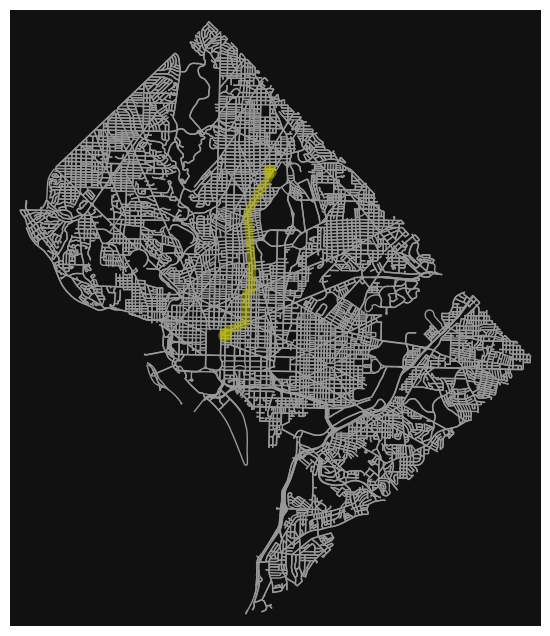

In [124]:
fig, ax = ox.plot_graph_route(dc_network_g, route, route_color="y", route_linewidth=6, node_size=0)

In [129]:
# Add up travel time and distance along the route
ox.routing.route_to_gdf(dc_network_g, route)['travel_time'].sum()

np.float64(549.620916646986)

In [132]:
ox.routing.route_to_gdf(dc_network_g, route)['length'].sum()

np.float64(6517.724752778894)

## Loop calculations for bulk processing

In [133]:
def shortest_paths_to_metro_center(graph, o_nodes, d_node, weight='length'):    
    # Calculate shortest paths between each O-D pair
    d_nodes = [d_node] * len(o_nodes)
    routes = ox.shortest_path(graph, o_nodes, d_nodes, weight=weight)
    # Gather data for edges along each route
    combined_route_edges = []
    for route_id, route in enumerate(routes):
        route_edges = ox.routing.route_to_gdf(dc_network_g, route)
        route_edges['route_id'] = route_id
        combined_route_edges.append(route_edges)
    combined_route_edges = pd.concat(combined_route_edges, axis=0)
    # Sum length and travel time for edges involved with each route
    route_summaries = combined_route_edges.groupby('route_id')[['length','travel_time']].sum()
    # Clean up column names
    route_summaries = route_summaries.rename(columns={'length':'dist_to_metro_center', 'travel_time': 'time_to_metro_center'})
    return route_summaries
        
routes = shortest_paths_to_metro_center(
    dc_network_g, 
    affordable_housing_nodes, 
    metro_center_node, 
    weight='length'
)

routes.head()

,dist_to_metro_center,time_to_metro_center
route_id,,
0,5082.777183,423.737160
1,4476.325277,364.131377
2,7309.568411,590.395258
3,4984.822043,413.287103
4,2529.357500,221.920956


In [135]:
# Add distance and time estimates back to affordable housing df
affordable_housing = pd.concat([affordable_housing, routes], axis=1)

In [136]:
affordable_housing.head()

,OBJECTID,MAR_WARD,ADDRESS,PROJECT_NAME,STATUS_PUBLIC,AGENCY_CALCULATED,TOTAL_AFFORDABLE_UNITS,LATITUDE,LONGITUDE,AFFORDABLE_UNITS_AT_0_30_AMI,...,AFFORDABLE_UNITS_AT_81_AMI,CASE_ID,MAR_ID,XCOORD,YCOORD,FULLADDRESS,GIS_LAST_MOD_DTTM,geometry,dist_to_metro_center,time_to_metro_center
0,119968,Ward 5,"1122 Bladensburg Road Northeast, Washington, D...",1122-1124 Bladensburg Rd NE,Completed 2015 to Date,DHCD,4,38.904778,-76.980637,0,...,0,None,73518.0,401676.80,137432.93,1122 BLADENSBURG ROAD NE,2024-09-23 09:00:26+00:00,POINT (328253.002 4308072.446),5082.777183,423.737160
1,120961,Ward 6,"1101 Pennsylvania Avenue Southeast, Washington...",Penn 11,Completed 2015 to Date,DHCD,3,38.882384,-76.991329,0,...,0,None,74406.0,400750.26,134954.45,1101 PENNSYLVANIA AVENUE SE,2024-09-23 09:00:26+00:00,POINT (327272.335 4305614.838),4476.325277,364.131377
2,120962,Ward 8,"1928 Naylor Road Southeast, Washington, Distri...",MEDES,Completed 2015 to Date,DHCD,3,38.872759,-76.976639,0,...,0,None,53759.0,402034.95,133880.20,1928 NAYLOR ROAD SE,2024-09-23 09:00:26+00:00,POINT (328533.19 4304512.676),7309.568411,590.395258
3,120963,Ward 6,"1339 E Street Southeast, Washington, District ...",Lockwood Apartments,Completed 2015 to Date,DHCD OP,13,38.882642,-76.986649,0,...,0,15-33,289426.0,401160.61,134975.43,1339 E STREET SE,2024-09-23 09:00:26+00:00,POINT (327683.052 4305626.819),4984.822043,413.287103
4,120964,Ward 6,"1720 New Jersey Avenue Northwest, Washington, ...",The Hoxton,Completed 2015 to Date,DHCD,1,38.913194,-77.017960,0,...,0,None,218457.0,398438.64,138369.63,1720 NEW JERSEY AVENUE NW,2024-09-23 09:00:26+00:00,POINT (325036.103 4309079.951),2529.357500,221.920956


## Compare to straight line distance

In [137]:
affordable_housing['straight_dist_to_metro_center'] = affordable_housing.distance(metro_center.geometry.iloc[0])

<Axes: >

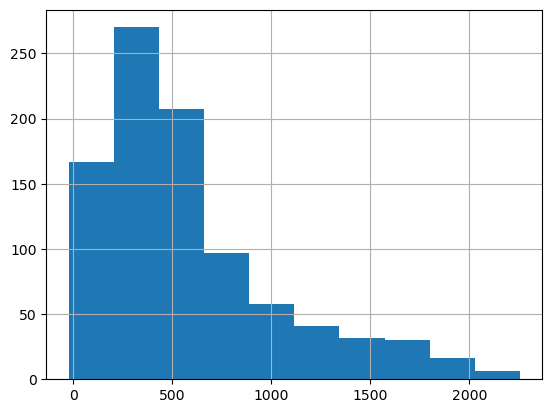

In [139]:
(affordable_housing['dist_to_metro_center'] - affordable_housing['straight_dist_to_metro_center']).hist()